In [1]:
%matplotlib inline
from lrgsglib.core import *
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
data_path = Path('data')
fig_path = data_path / Path('figures')
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


In [2]:
data_dict = {}
int_label_pos_map = {}

for pat in patients_list:
    data_dict[pat] = {}
    #
    patnum = int(pat.split('_')[-1])
    patpath = mat_path / pat
    #
    ch_dat = pd.read_csv(patpath / f'Implant_pat_{patnum}.csv')
    ch_names = pd.read_csv(patpath / 'channel_labels.csv')
    #
    int_label_pos_map[pat] = ch_names.merge(ch_dat,on='label', how='left')
    df = int_label_pos_map[pat][['x', 'y', 'z']]
    df = df.apply(lambda s: s.str.replace(',', '.', regex=False).astype(float))
    #
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        try:
            # Load the .mat file using scipy.io.loadmat
            # This is the preferred method for loading .mat files
            tmp_mat = loadmat(str(mat_path / pat / f'{phase}'))
        except Exception as e:
            # If loading fails, fall back to h5py
            print(f'{type(e).__name__} loading {pat} {phase}: {e}. ',
                  f'Continuing with h5py', end='\r', flush=True)
            tmp_mat = {}
            f = h5py.File(mat_path / pat / f'{phase}.mat')
            for k, v in f.items():
                tmp_mat[k] = np.array(v)
            pass
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = data_dict[pat][phase]['data'].shape
        if tmp_shape[0] > tmp_shape[1]:
            # Transpose the data if the first dimension is bigger
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Extract the parameters from the loaded data
            # Check if 'Parameters' is in the loaded data
            # If not, skip to the next iteration
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

### Timeseries

In [3]:
pat = 'Pat_02'
phase = 'rsPre'
data = data_dict[pat][phase]['data'][:, :100000]

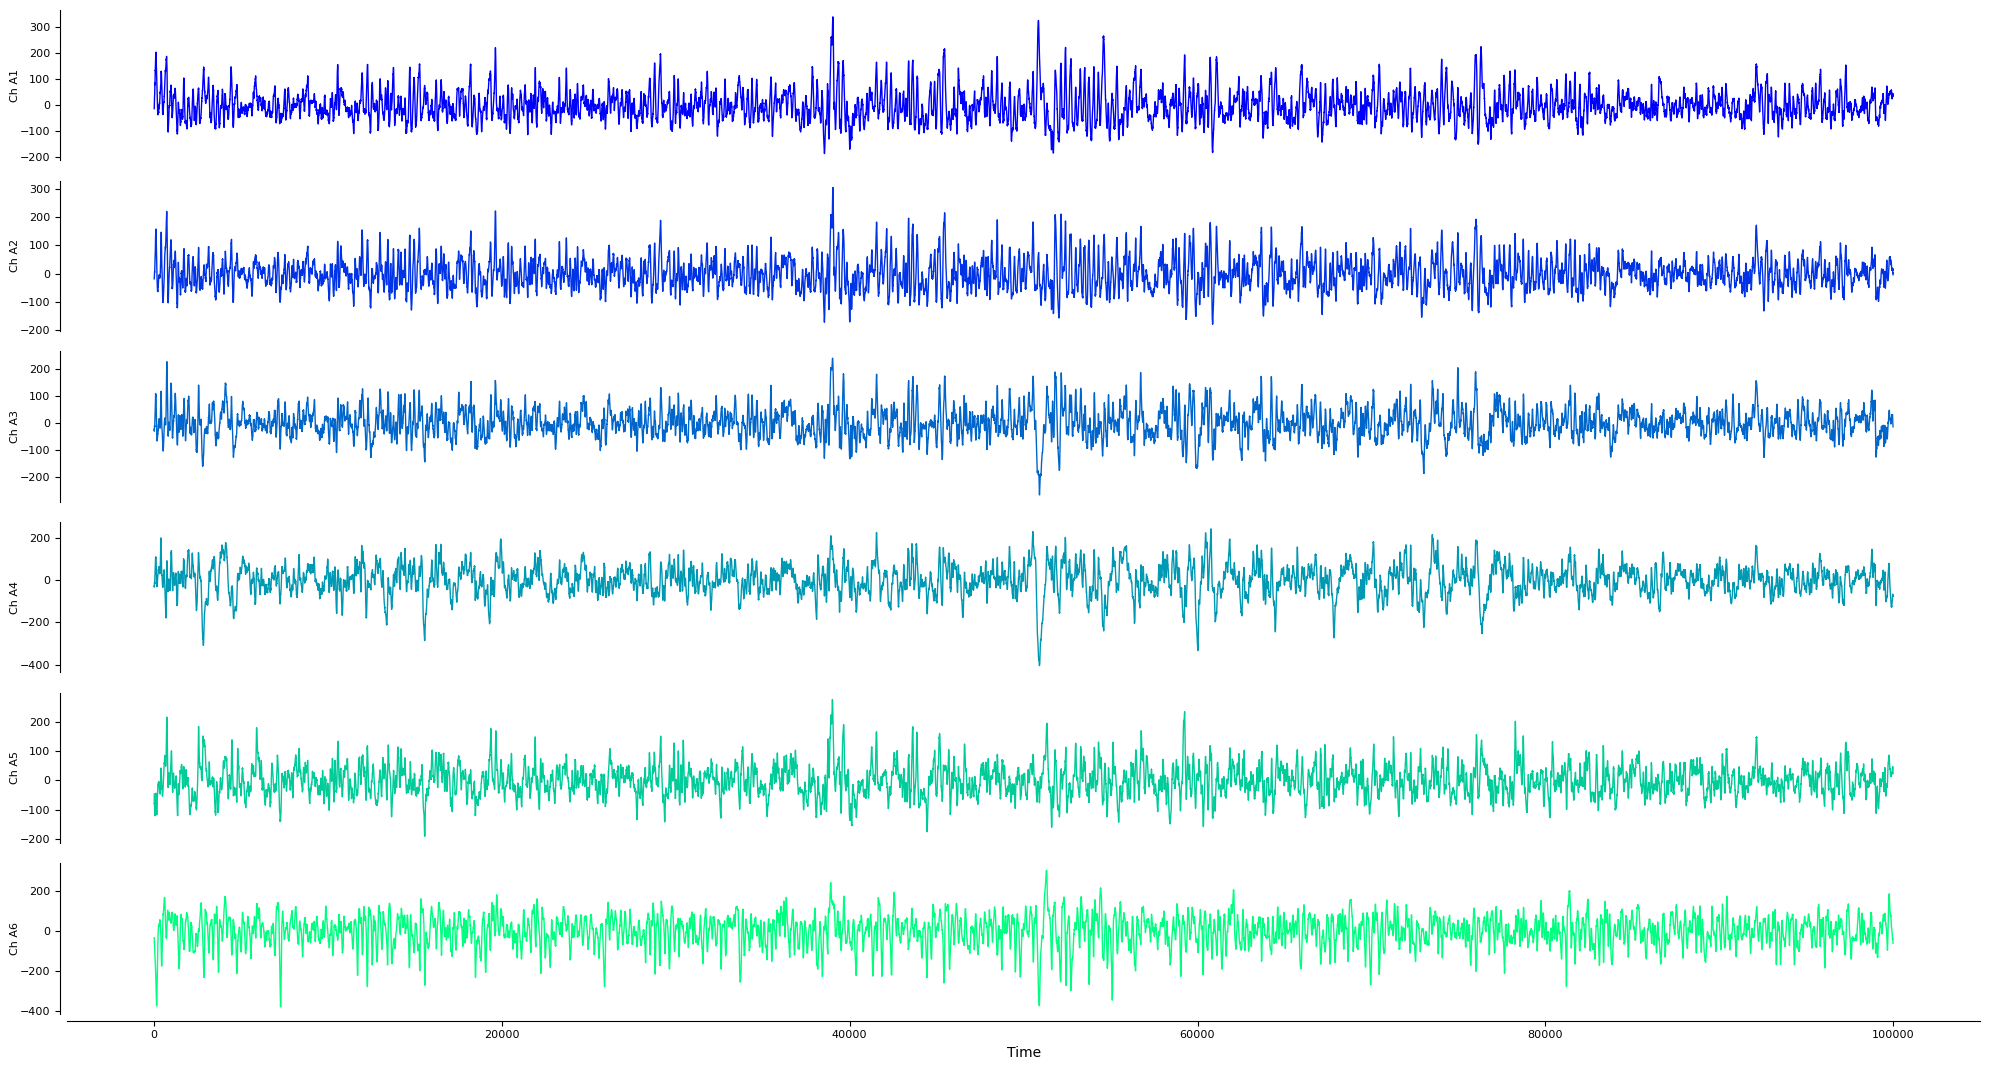

In [4]:
n = 6
m = data.shape[1]
t = np.arange(m)

colors = plt.cm.winter(np.linspace(0, 1, n))  # or any colormap


fig, axes = plt.subplots(n, 1, sharex=True, figsize=(20, 1.8*n))

for i, ax in enumerate(axes):
    ax.plot(t, data[i], color=colors[i], rasterized=True, lw=1)
    
    # common styling
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))      # detach left spine
    ax.tick_params(axis='y', labelsize=8)

    if i < n - 1:                                       # hide x-axis on upper panels
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    else:                                               # bottom panel: show x-axis
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_position(('outward', 5))# detach bottom spine
        ax.set_xlabel('Time')
        ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(f'Ch {int_label_pos_map[pat].iloc[i]['label']}', labelpad=0, fontsize=8)

fig.tight_layout()
fig.savefig(fig_path / f'{pat}_{phase}_raw.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

### Correlation Matrices

In [8]:
pat = 'Pat_02'
phase = 'rsPre'

In [6]:
sample_rate = data_dict[pat][phase]['fs']
filter_order = data_dict[pat][phase]['filter_order']
data = data_dict[pat][phase]['data']

In [7]:
corr_nets = {}
corr_nets_unfilt = {}
for band_name, (low, high) in BRAIN_BANDS.items():
    try:
        filt = bandpass_sos(data, low, high, sample_rate, int(filter_order))
        assert not np.allclose(filt, data, rtol=1e-5, atol=1e-8), \
            f'Band-pass output is indistinguishable from input in {band_name} band'
    except AssertionError as e:
        print(f'Band-pass output is indistinguishable from input in {band_name} band: {e}')
        continue
    C_unfilt = build_corr_network(filt)
    C_filt = build_corr_network(filt, threshold=None, filter_type='abs')
    G_filt = nx.from_numpy_array(C_filt)
    #
    Th, Einf, Pinf = compute_threshold_stats(G_filt, n_points=100)
    Pinf_diff = np.diff(Pinf)
    jumps = np.where(Pinf_diff != 0)[0]
    #
    C_tmp = C_filt.copy()
    C_tmp = build_corr_network(C_tmp, threshold=Th[jumps[0]])
    #
    corr_nets_unfilt[band_name] = C_unfilt
    corr_nets[band_name] = C_tmp

Computing threshold stats: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


/tmp/ipykernel_8428/193045757.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


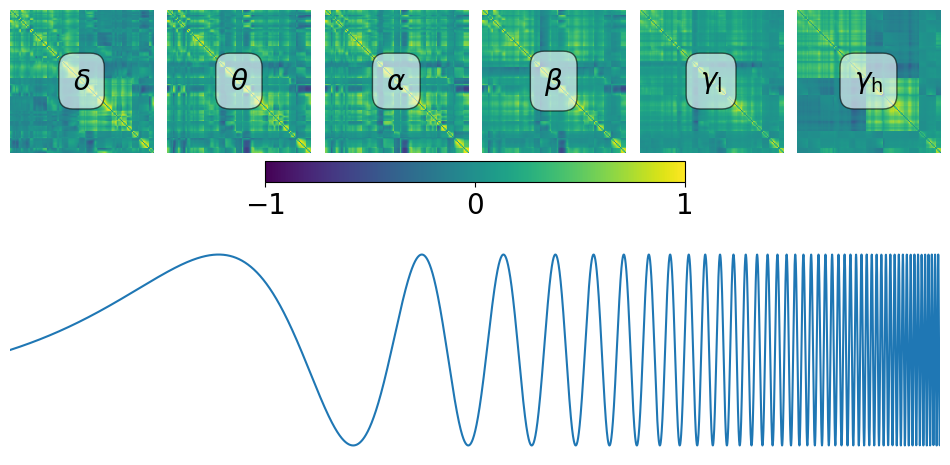

In [ ]:
# Creazione della figura
fig = plt.figure(figsize=(2*len(BRAIN_BANDS), 1.5*len(BRAIN_BANDS)))
gs = fig.add_gridspec(2, len(BRAIN_BANDS), height_ratios=[1, 0.5], hspace=0.2, wspace=0.1)

# Plot delle matrici di correlazione
for i, (band,C) in enumerate(corr_nets_unfilt.items()):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(C, vmin=-1, vmax=1)
    label = BRAIN_BANDS_LABELS[band]
    ax.text(
        0.5, 0.5, label,
        transform=ax.transAxes,
        fontsize=20,
        ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5')
    )
    ax.axis('off')
cbar = fig.colorbar(im, ax=fig.get_axes()[:len(BRAIN_BANDS)], orientation='horizontal', fraction=0.05, pad=0.02)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_xticks([-1, 0, 1])


t = np.linspace(0, 1, 10000)
f0, f1 = 0.5, 300
f_inst = f0 * (f1 / f0) ** t
phase = 2 * np.pi * (f0 * ((f1 / f0) ** t - 1) / np.log(f1 / f0))
signal = np.sin(phase)

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(t, signal)
ax2.set_xlim(0, 1)

ax2.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])


ax2.set_facecolor('none') 
fig.tight_layout()
fig.savefig(fig_path / f'{pat}_poster_corr.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

### Thresholding protocol

In [180]:
C_filt = corr_nets_unfilt['alpha'].copy()
C_filt = build_corr_network(C_filt, filter_type='abs')
G = nx.from_numpy_array(C_filt)
Th, Einf, Pinf = compute_threshold_stats(G)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]
not_in_giant = {}
for i,jump in enumerate(jumps):
    C_tmp = C_filt.copy()
    C_tmp[C_tmp < Th[jump]*1.1] = 0
    G = nx.from_numpy_array(C_tmp)
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc)
    # get the nodes not in the giant component
    not_in_giant[i] = set(G.nodes()) - set(Gcc.nodes())
    if i > 0:
        not_in_giant[i] = not_in_giant[i]-not_in_giant[i-1]

Computing threshold stats:   0%|          | 0/117 [00:00<?, ?it/s]

Computing threshold stats: 100%|██████████| 117/117 [00:02<00:00, 42.14it/s]


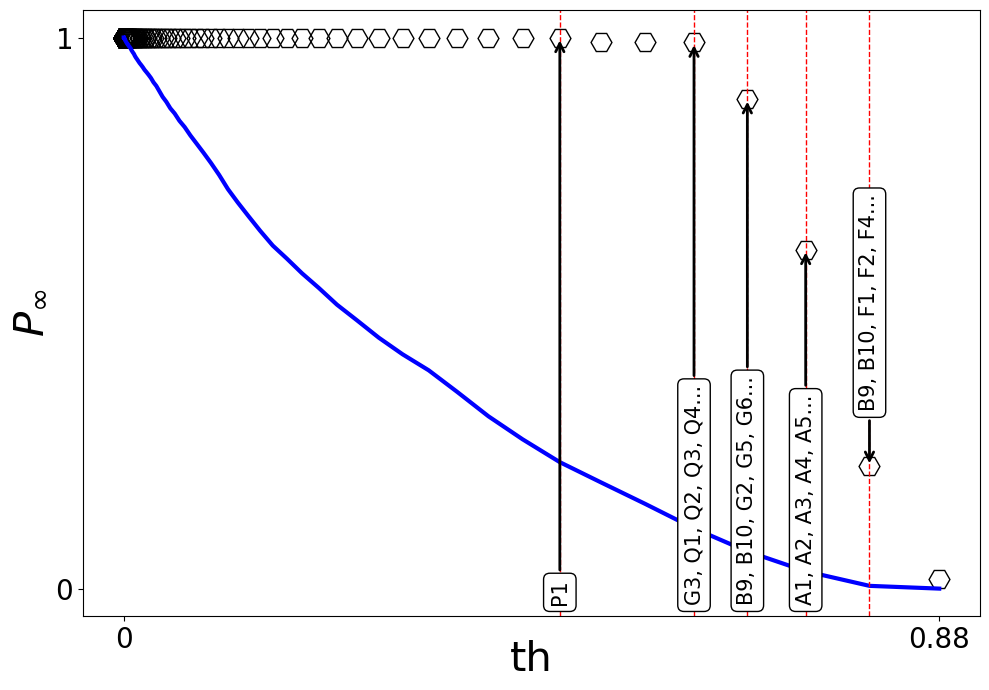

In [ ]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 7))
#
maxlables = 5
ax.plot(Th, Pinf, 'kH', ms=15, mec='k', mfc='none', label='Pinf')
ax.plot(Th, Einf, lw=3, color='b')
for i,jump in enumerate(jumps):
    ax.axvline(Th[jump], color='r', linestyle='--', lw=1)
    lablist = [int_label_pos_map[pat]['label'][n] for n in not_in_giant[i]]
    if len(lablist) < maxlables:
        not_in_giant_str = ', '.join(lablist)
    else:
        not_in_giant_str = ', '.join(lablist[:maxlables]) + '...'
    ax.annotate(not_in_giant_str, xy=(Th[jump], Pinf[jump]),
                xytext=(Th[jump], Pinf[jump]+0.1 if Pinf[jump] < 0.5 else -0.03),
                rotation=90,
                fontsize=15,
                ha='center',
                va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'),
                arrowprops=dict(arrowstyle="->", lw=2, color='black'))
ax.set_xticks([0, Th[-1]])
ax.set_xticklabels([0, round(Th[-1], 2)], fontsize=20)
ax.set_yticks([0, 1])
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('th', fontsize=30, labelpad=-10)
ax.set_ylabel(r'$P_\infty$', fontsize=30)
fig.tight_layout()
fig.savefig(fig_path / f'{pat}_Pinf.pdf', bbox_inches='tight', transparent=True)
plt.close('all')

### Correlations thresholded|

In [10]:
fig, ax = plt.subplots(1, len(BRAIN_BANDS), figsize=(16, 10))
for i, (band_name, C_filt) in enumerate(corr_nets.items()):
    kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_filt.min(), vmax=C_filt.max())
    im = ax[i].imshow(C_filt, **kwargs_imshow)
    ax[i].axis('off')
    # div, cax, clb = imshow_colorbar_caxdivider(im, ax[0][i])
    #
    # G = nx.from_numpy_array(C_filt)
    # Gcc = max(nx.connected_components(G), key=len)
    # Gcc = G.subgraph(Gcc)
    # widths = [ Gcc[u][v]['weight'] for u, v in Gcc.edges()]
    # coords = df[['x','y']].replace(',', '.', regex=True).astype(float).values
    # pos = nx.spring_layout(Gcc, seed=0)
    # nx.draw(Gcc, pos=pos, ax=ax[1][i], node_size=50, alpha=0.5, width=widths, edgecolors='k', node_color=(1, 0, 1, 0.5))
    # ax[1][i].margins(0)
    # x_vals, y_vals = zip(*pos.values())
    # dx, dy = max(x_vals)-min(x_vals), max(y_vals)-min(y_vals)
    # pad = 0.02
    # ax_curr = ax[1][i]
    # ax_curr.set_xlim(min(x_vals)-pad*dx, max(x_vals)+pad*dx)
    # ax_curr.set_ylim(min(y_vals)-pad*dy, max(y_vals)+pad*dy)
    # ax_curr.set_aspect('equal')
    # ax_curr.axis('off')
fig.tight_layout()
fig.savefig(fig_path / f'{pat}_{phase}_corr_nets.pdf', bbox_inches='tight', transparent=True) 
plt.close('all')

### Laplacian Protocol

In [412]:
pat = 'Pat_02'
phase = 'rsPre'
band = 'delta'
filttime = -1
data = data_dict[pat]['taskLearn']['data'][:, :filttime]
low, high = BRAIN_BANDS[band]
sample_rate = data_dict[pat]['taskLearn']['fs']
filter_order = data_dict[pat]['taskLearn']['filter_order']
filt = bandpass_sos(data, low, high, sample_rate, int(filter_order))

In [416]:
C = build_corr_network(filt, threshold=None, filter_type='abs')
G = nx.from_numpy_array(C)
Th, Einf, Pinf = compute_threshold_stats(G)
Pinf_diff = np.diff(Pinf)
jumps = np.where(Pinf_diff != 0)[0]
C_tmp = C.copy()
C_tmp = build_corr_network(C_tmp, threshold=Th[jumps[0]])
G = nx.from_numpy_array(C_tmp)
Gcc = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(Gcc)

Computing threshold stats: 100%|██████████| 117/117 [00:04<00:00, 27.64it/s]


In [417]:
# network entropy
net_ent = entropy(Gcc, t2=3)
tau_scale = net_ent[-1]
speC = net_ent[1]

# laplacian-based distances
spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')
FlatClusteringTh, *_ = compute_optimal_threshold(linkage_matrix)
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/funcs/infocomm.py:32: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


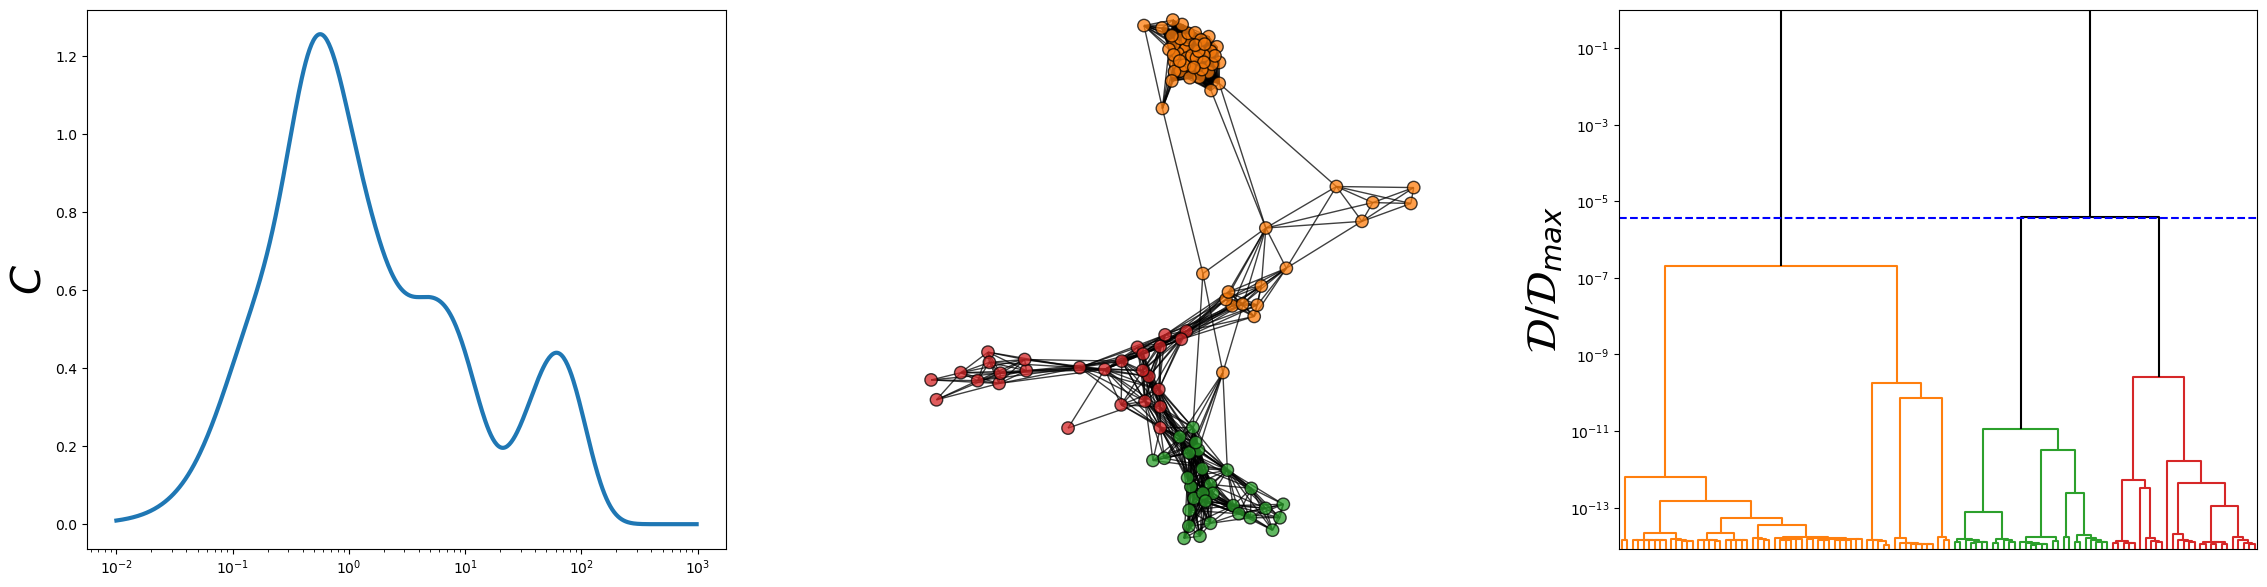

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(28, 7))
ax[0].plot(tau_scale[:-1], speC, label=r'$C$',lw=3)
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$C$', fontsize=30)
dendro = dendrogram(
    linkage_matrix,
    ax=ax[2],
    color_threshold=FlatClusteringTh,
    above_threshold_color='k',
    leaf_font_size=9,
    orientation='top',
    no_labels=True,
)
leaf_label_colors = {
    lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
}
Gcc = nx.convert_node_labels_to_integers(Gcc)
node_colors = [leaf_label_colors[str(n)] for n in Gcc.nodes()]
# crea un inset per il grafo
# axins = inset_axes(
#     ax[0],
#     width="50%",    # larghezza 30% dell'asse principale
#     height="50%",   # altezza 30%
#     loc='upper right',
# )
# disegna il grafo nella finestra inset
pos = nx.spring_layout(Gcc, seed=5)
nx.draw(
    Gcc,
    pos=pos,
    ax=ax[1],
    node_size=80,
    alpha=0.75,
    edgecolors='k',
    node_color=node_colors
)
x_vals, y_vals = zip(*pos.values())
dx, dy = max(x_vals)-min(x_vals), max(y_vals)-min(y_vals)
pad = 0.02
ax[1].set_xlim(min(x_vals)-pad*dx, max(x_vals)+pad*dx)
ax[1].set_ylim(min(y_vals)-pad*dy, max(y_vals)+pad*dy)
ax[1].set_aspect('equal')
# ax[2].axis('off')
# ax[0].legend(loc='upper left', fontsize=30, handlelength=1.5)

ax[2].set_yscale('log')
tmin = linkage_matrix[:, 2][0] * 0.8
tmax = linkage_matrix[:, 2][-1] * 1.01
ax[2].axhline(FlatClusteringTh, color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
ax[2].set_ylim(tmin, tmax)
ax[2].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$', fontsize=30)

fig.savefig(fig_path / f'{pat}_{phase}_{band}_clustering.pdf', bbox_inches='tight')